# 技術側の分析


<a id=top></a>


<a href="#data">データインポート</a>


---


<a id=init></a>

## **1. モジュールインポート・初期条件設定**


In [1]:
import pandas as pd
import numpy as np
import sys

sys.path.append("../../src")
from ecomplexity import ecomplexity
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import io

import matplotlib.ticker as ptick
import networkx as nx
import networkx.algorithms.bipartite as bip

plt.rcParams["font.family"] = "Meiryo"
plt.rcParams["font.size"] = 20

# 小数点以下 桁数 6
pd.options.display.float_format = "{:.3f}".format

In [2]:
import initial_condition
from analysis import weight
from analysis import rank as vr

In [3]:
global data_dir, ex_dir, output_dir
data_dir = "../../data/processed/internal/technology/"
ex_dir = "../../data/processed/external/schmoch/"
output_dir = "../../output/figures/"

In [4]:
# 初期条件
ar = initial_condition.AR
year_style = initial_condition.YEAR_STYLE

year_start = initial_condition.YEAR_START
year_end = initial_condition.YEAR_END
year_range = initial_condition.YEAR_RANGE

classification = initial_condition.CLASSIFICATION
class_weight = initial_condition.CLASS_WEIGHT
applicant_weight = initial_condition.APPLICANT_WEIGHT

extract_population = initial_condition.EXTRACT_POPULATION
top_p_or_num = initial_condition.TOP_P_OR_NUM

color_list = initial_condition.COLOR_LIST

fig_name_base = f"{ar}_{year_style}_{year_start}_{year_end}_{classification}_{class_weight}_{applicant_weight}_{extract_population}_{top_p_or_num[0]}_{top_p_or_num[1]}.png"

In [5]:
# 条件確認
fig_name_base

'app_nendo_1981_2010_schmoch35_fraction_fraction_all_p_3.png'

In [6]:
period_order_dict = {
    f"{period_start}-{period_start+year_range-1}": i
    for i, period_start in enumerate(range(year_start, year_end + 1, year_range))
}

period_order_dict[f"{year_start}-{year_end}"] = len(period_order_dict)
period_order_dict

{'1981-1990': 0, '1991-2000': 1, '2001-2010': 2, '1981-2010': 3}

<a href=#top>TOP に戻る</a>

---


<a id="data"></a>

## **2. データインポート**


In [7]:
df = pd.read_csv(
    f"{data_dir}{ar}_{year_style}_{top_p_or_num[0]}_{top_p_or_num[1]}.csv", sep=","
)

schmoch_df = pd.read_csv(
    f"{ex_dir}35.csv", encoding="utf-8", sep=",", usecols=["Field_number", "Field_en"]
).drop_duplicates()

df = (
    pd.merge(
        df, schmoch_df, left_on=classification, right_on="Field_number", how="left"
    )
    .drop(columns=["Field_number", classification])

    .rename(columns={"Field_en": classification})

)
df = df.sort_values(
    f"{ar}_{year_style}_period", key=lambda col: col.map(period_order_dict)
)

df

app_nendo_period    reg_num  right_person_name  ubiquity    tci   ki_1  \
0         1981-1990  53259.148                917       306 -1.355  5.843   
20        1981-1990  22493.002                889       477  0.459  6.872   
21        1981-1990      1.000                  2         2  0.920 10.500   
22        1981-1990  14612.727                886       495  0.948  7.154   
23        1981-1990   9750.837                626       350  0.490  7.189   
..              ...        ...                ...       ...    ...    ...   
56        1981-2010    758.333                147       117 -0.873  9.624   
55        1981-2010  70208.393               1282       490  0.717  7.680   
54        1981-2010  96985.937               1111       351  0.769  8.308   
60        1981-2010  91313.697               1438       417  0.262  6.441   
69        1981-2010 112115.190               1234       412  0.459  5.684   

      ki_2  ki_3    ki_4  ki_5  ...   ki_12  ki_13   ki_14  ki_15   ki_16  \
0  305.401 6.283 314.224 6.433  ... 326.062  6.567 326.679  6.573 327.037   
20 362.784 6.644 339.953 6.603  ... 328.135  6.585 327.847  6.584 327.699   
21 297.635 7.137 332.642 6.709  ... 328.606  6.590 328.124  6.587 327.860   
22 358.657 6.789 338.455 6.678  ... 328.474  6.591 328.067  6.588 327.836   
23 344.740 6.726 337.000 6.624  ... 328.224  6.585 327.896  6.584 327.725   
..     ...   ...     ...   ...  ...     ...    ...     ...    ...     ...   
56 309.205 7.723 341.300 7.412  ... 357.720  7.318 358.392  7.318 358.768   
55 392.916 7.454 373.079 7.382  ... 360.262  7.326 359.808  7.323 359.558   
54 390.213 7.586 374.709 7.418  ... 360.357  7.326 359.858  7.324 359.585   
60 385.161 7.046 369.821 7.208  ... 359.730  7.316 359.492  7.318 359.373   
69 388.933 6.721 372.758 7.074  ... 360.099  7.311 359.699  7.317 359.488   

    ki_17   ki_18  ki_19   ki_20                                schmoch35  
0   6.577 327.244  6.579 327.364  Electrical machinery, apparatus, energy  
20  6.583 327.621  6.583 327.580              Surface technology, coating  
21  6.585 327.714  6.584 327.633     Micro-structural and nano-technology  
22  6.585 327.705  6.584 327.629                     Chemical engineering  
23  6.583 327.635  6.583 327.586                 Environmental technology  
..    ...     ...    ...     ...                                      ...  
56  7.319 358.978  7.319 359.095     Micro-structural and nano-technology  
55  7.322 359.419  7.321 359.342              Surface technology, coating  
54  7.322 359.434  7.321 359.350                    Materials, metallurgy  
60  7.319 359.312  7.320 359.280                            Machine tools  
69  7.319 359.375  7.320 359.315                        Civil engineering  

[140 rows x 26 columns]

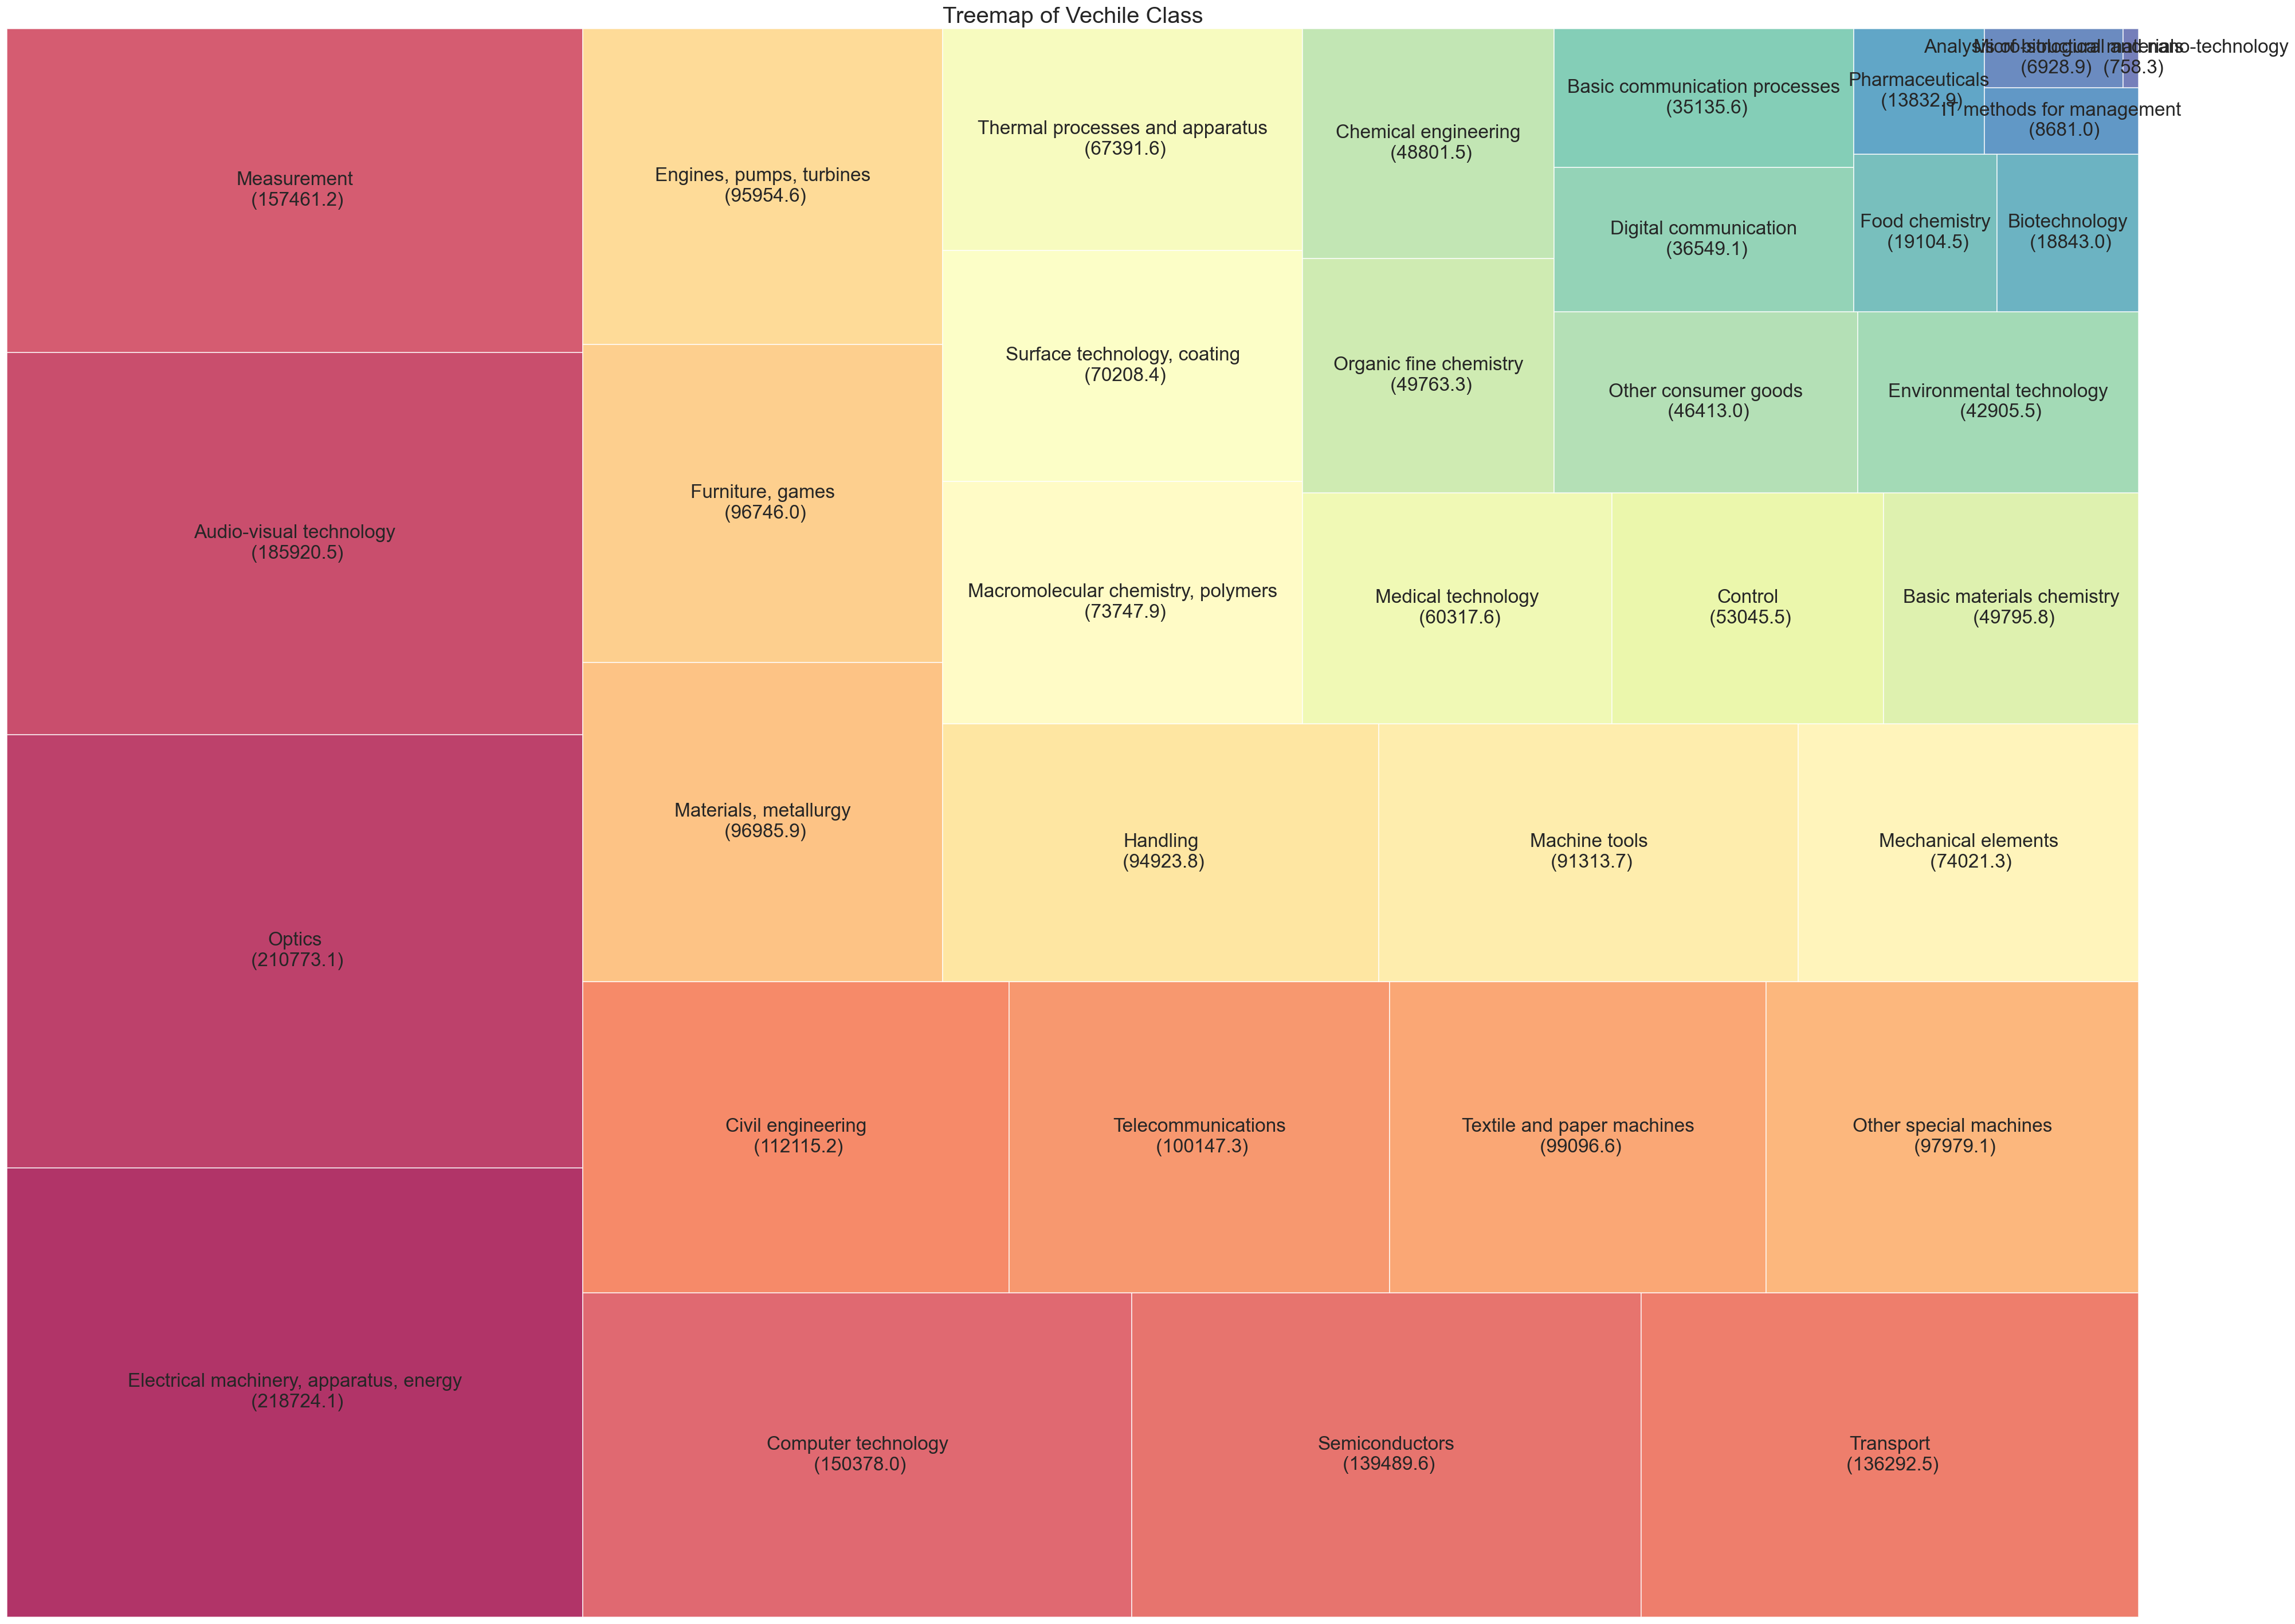

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import squarify

sns.set_style("darkgrid")
df_2col = df[df[f"{ar}_{year_style}_period"] == f"{year_start}-{year_end}"][
    ["schmoch35", "reg_num"]
].sort_values("reg_num", ascending=False)
# df_raw = pd.read_csv("https://github.com/selva86/datasets/raw/master/import squarify.csv")

# df_raw = pd.read_csv("https://github.com/selva86/datasets/raw/master/mpg_ggplot2.csv")
# display(df_raw)
# display(df_raw.groupby('class').size().reset_index(name='counts'))
labels = df_2col.apply(lambda x: str(x[0]) + "\n (" + str(round(x[1], 1)) + ")", axis=1)
sizes = df_2col["reg_num"].values.tolist()
colors = [plt.cm.Spectral(i / float(len(labels))) for i in range(len(labels))]
# colors = color_list
# display(sizes)
plt.figure(figsize=(40, 30), dpi=120)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8)

plt.title("Treemap of Vechile Class")
plt.axis("off")
plt.show()

In [21]:
df_2col

Empty DataFrame
Columns: [schmoch35, reg_num]
Index: []

c:\Users\rin\anaconda3\envs\economic_complexity\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


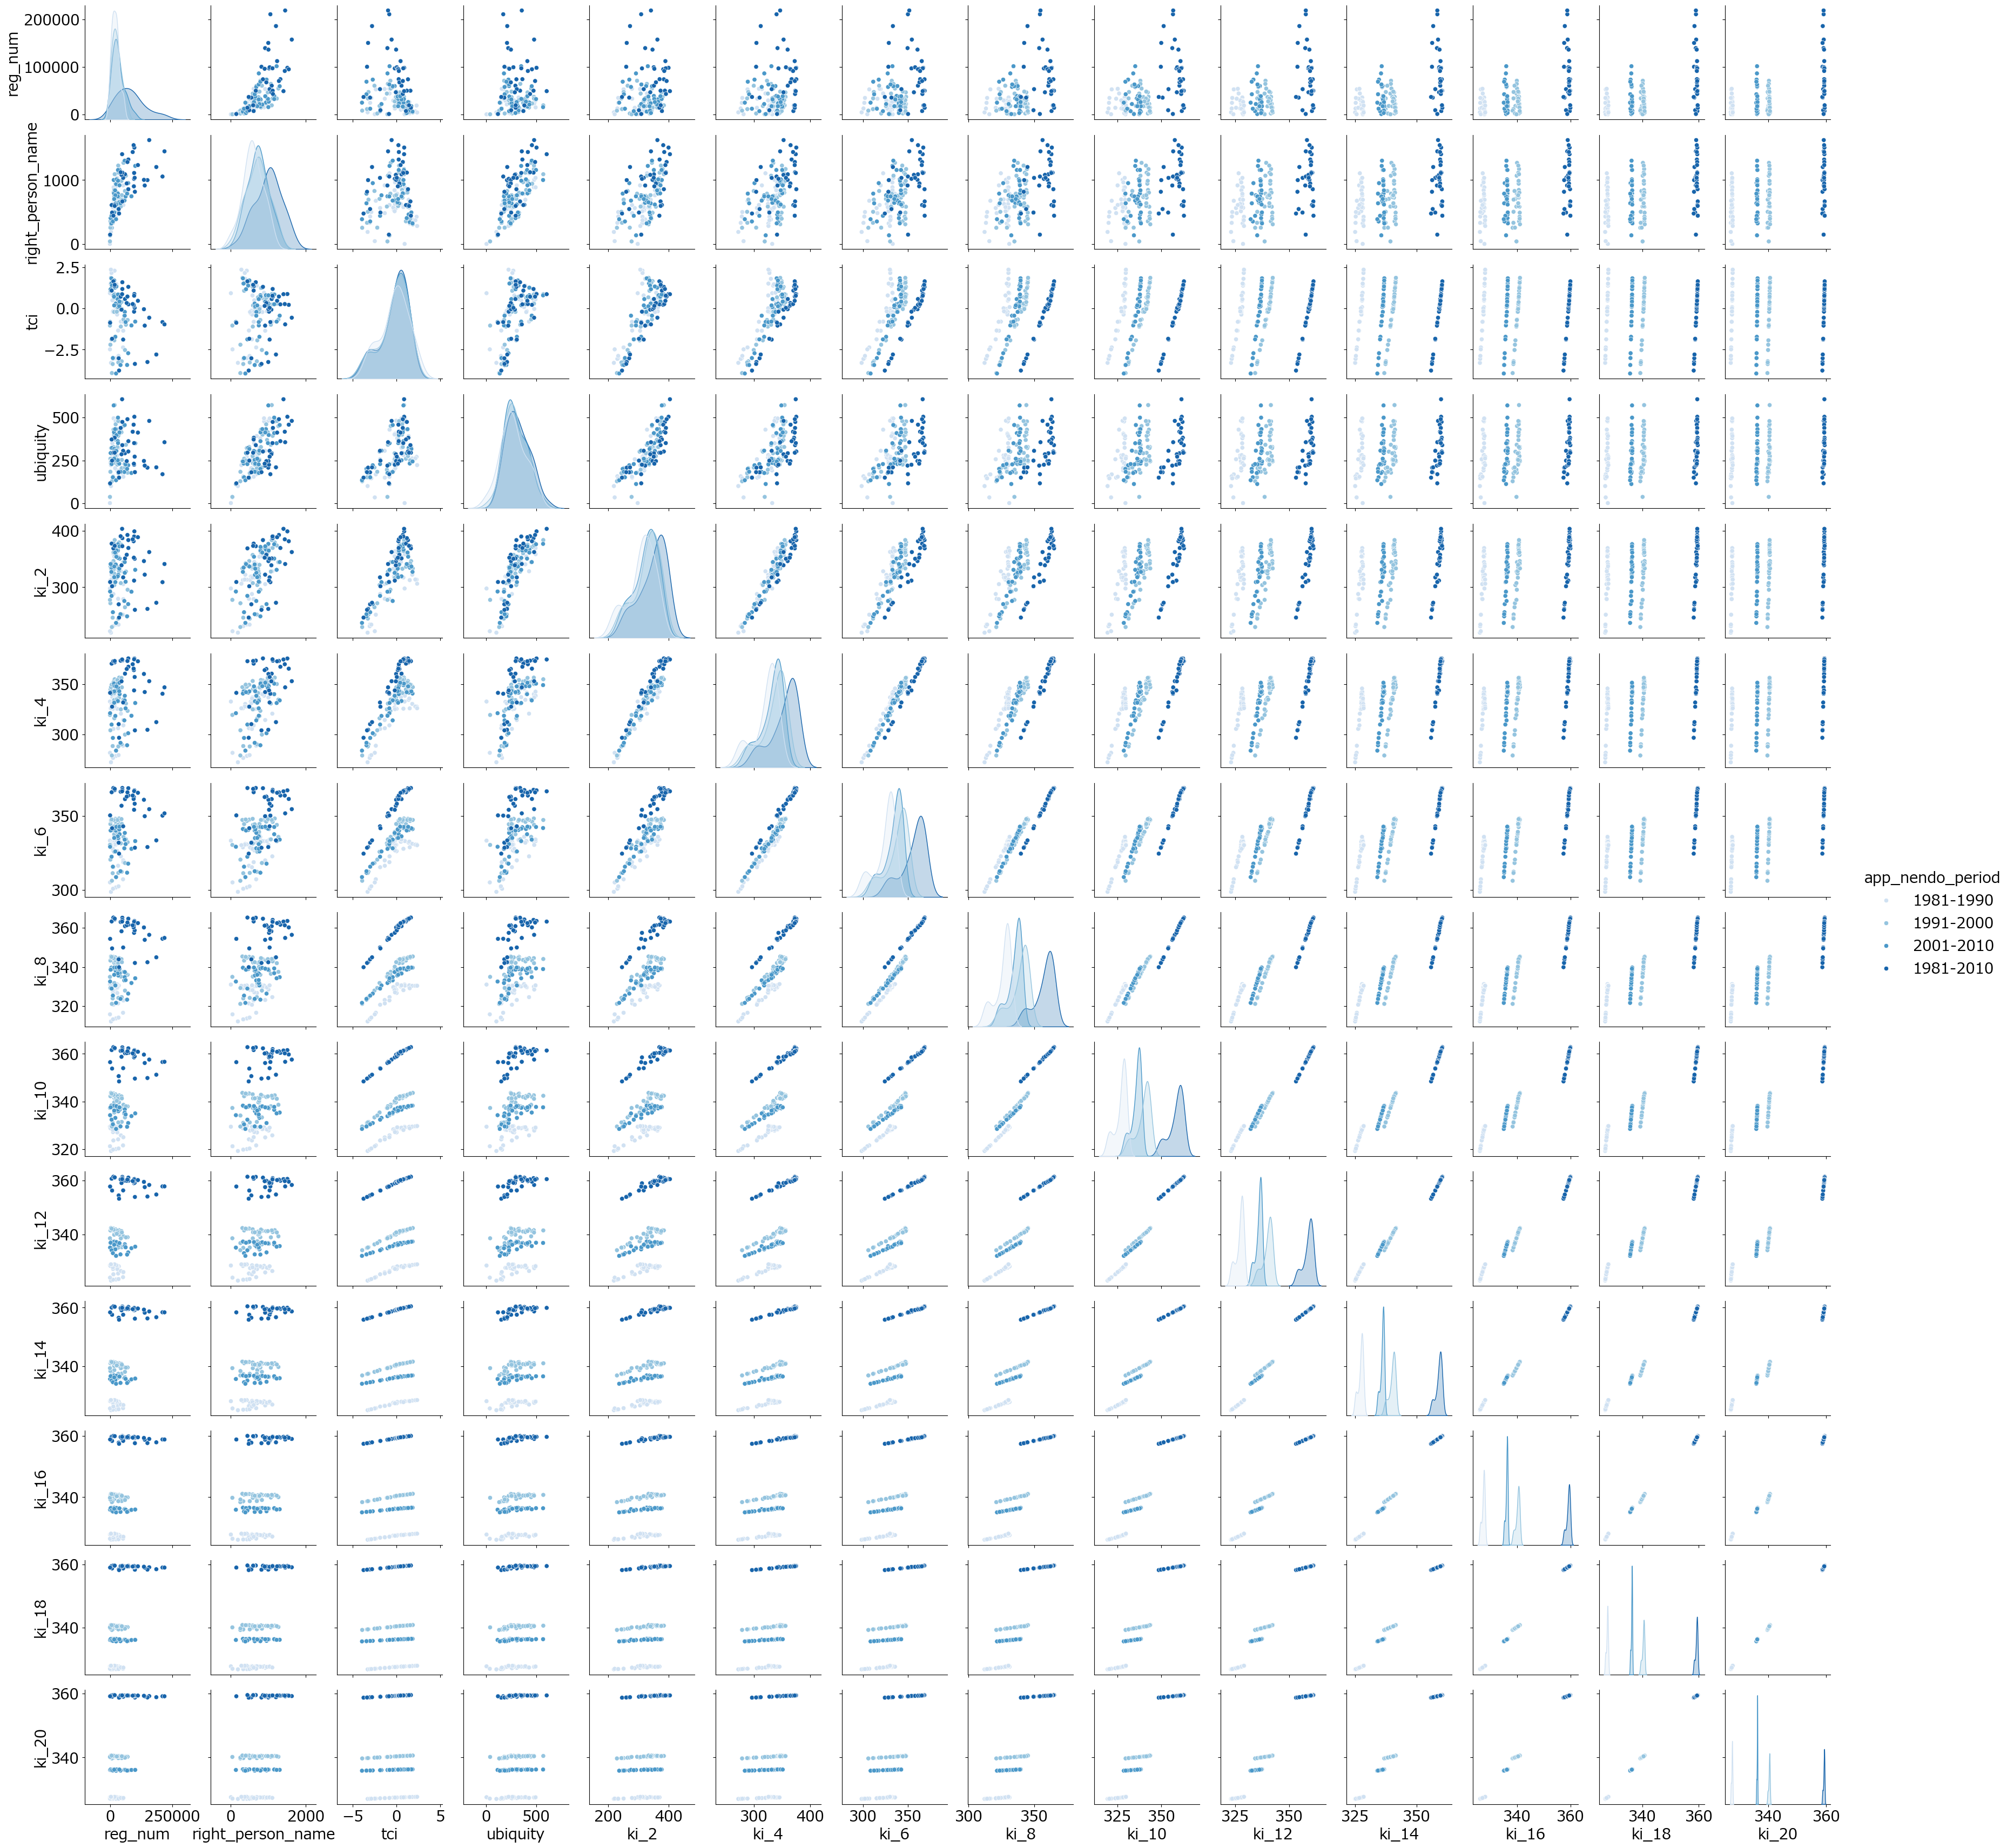

In [13]:
pg = sns.pairplot(
    df[
        [
            f"{ar}_{year_style}_period",
            classification,
            "reg_num",
            "right_person_name",
            "tci",
            "ubiquity",
        ]
        + [f"ki_{i}" for i in range(2, 20 + 1, 2)]
    ],

    hue=f"{ar}_{year_style}_period",
    palette="Blues",
)
pg

In [14]:
df[
    df["schmoch35"].isin(
        [
            "Analysis of biological materials",

            "Organic fine chemistry",

            "Biotechnology",

            "Pharmaceuticals",

            "Macromolecular chemistry, polymers",

            "Food chemistry",

            "Basic materials chemistry",

            "Materials, metallurgy",

            "Surface technology, coating",

            "Chemical engineering",

            "Other special machines",
        ]
    )
    & (df[f"{ar}_{year_style}_period"] == "1981-2010")
]

app_nendo_period   reg_num  right_person_name  ubiquity   tci  ki_1  \
49        1981-2010 18843.017                613       382 1.351 8.730   
48        1981-2010 49763.293                666       339 1.585 8.283   
45        1981-2010  6928.900                609       372 1.080 8.470   
50        1981-2010 13832.883                443       295 1.640 8.451   
51        1981-2010 73747.874                857       302 1.305 8.272   
53        1981-2010 49795.784               1116       474 1.175 8.086   
63        1981-2010 97979.104               1508       504 0.871 7.030   
52        1981-2010 19104.525                596       295 1.427 8.068   
57        1981-2010 48801.458               1404       606 0.860 7.990   
55        1981-2010 70208.393               1282       490 0.717 7.680   
54        1981-2010 96985.937               1111       351 0.769 8.308   

      ki_2  ki_3    ki_4  ki_5  ...   ki_12  ki_13   ki_14  ki_15   ki_16  \
49 374.521 7.948 371.694 7.632  ... 360.959  7.341 360.232  7.331 359.810   
48 373.021 8.008 373.465 7.681  ... 361.269  7.345 360.411  7.333 359.912   
45 377.528 7.833 370.424 7.567  ... 360.606  7.336 360.027  7.329 359.692   
50 369.096 8.036 372.847 7.694  ... 361.328  7.346 360.448  7.333 359.935   
51 383.828 7.742 375.637 7.538  ... 360.995  7.337 360.238  7.329 359.808   
53 387.291 7.723 373.870 7.527  ... 360.802  7.335 360.130  7.328 359.747   
63 399.332 7.263 375.559 7.317  ... 360.524  7.325 359.955  7.323 359.640   
52 373.474 7.790 373.042 7.579  ... 361.101  7.339 360.311  7.330 359.853   
57 403.870 7.550 374.578 7.420  ... 360.447  7.328 359.917  7.324 359.621   
55 392.916 7.454 373.079 7.382  ... 360.262  7.326 359.808  7.323 359.558   
54 390.213 7.586 374.709 7.418  ... 360.357  7.326 359.858  7.324 359.585   

    ki_17   ki_18  ki_19   ki_20                           schmoch35  
49  7.326 359.566  7.323 359.427                       Biotechnology  
48  7.327 359.625  7.324 359.460              Organic fine chemistry  
45  7.325 359.499  7.323 359.389    Analysis of biological materials  
50  7.327 359.638  7.324 359.468                     Pharmaceuticals  
51  7.325 359.563  7.323 359.424  Macromolecular chemistry, polymers  
53  7.325 359.529  7.323 359.405           Basic materials chemistry  
63  7.322 359.465  7.321 359.367              Other special machines  
52  7.326 359.590  7.323 359.440                      Food chemistry  
57  7.323 359.455  7.322 359.363                Chemical engineering  
55  7.322 359.419  7.321 359.342         Surface technology, coating  
54  7.322 359.434  7.321 359.350               Materials, metallurgy  

[11 rows x 26 columns]

1981-2010 -0.069


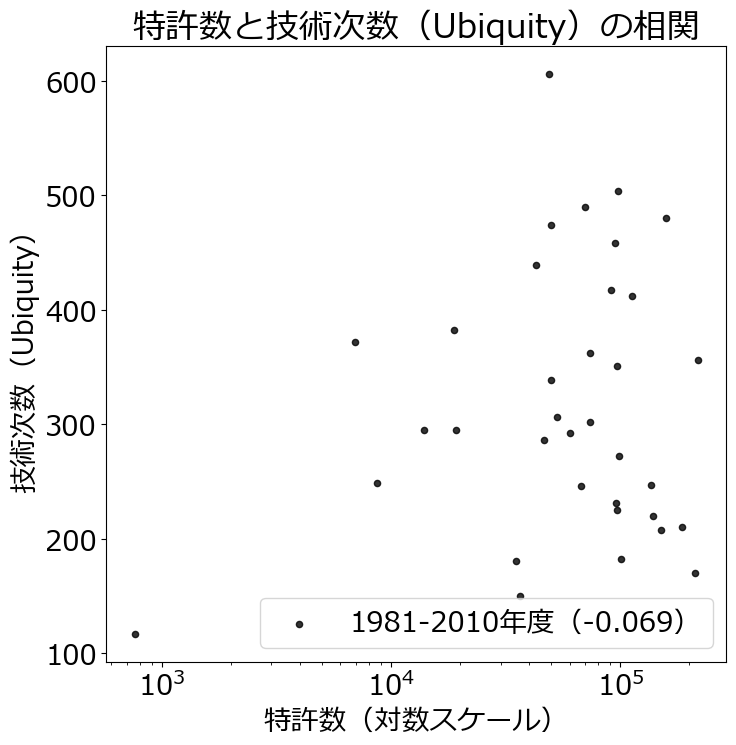

1981-2010 -0.292


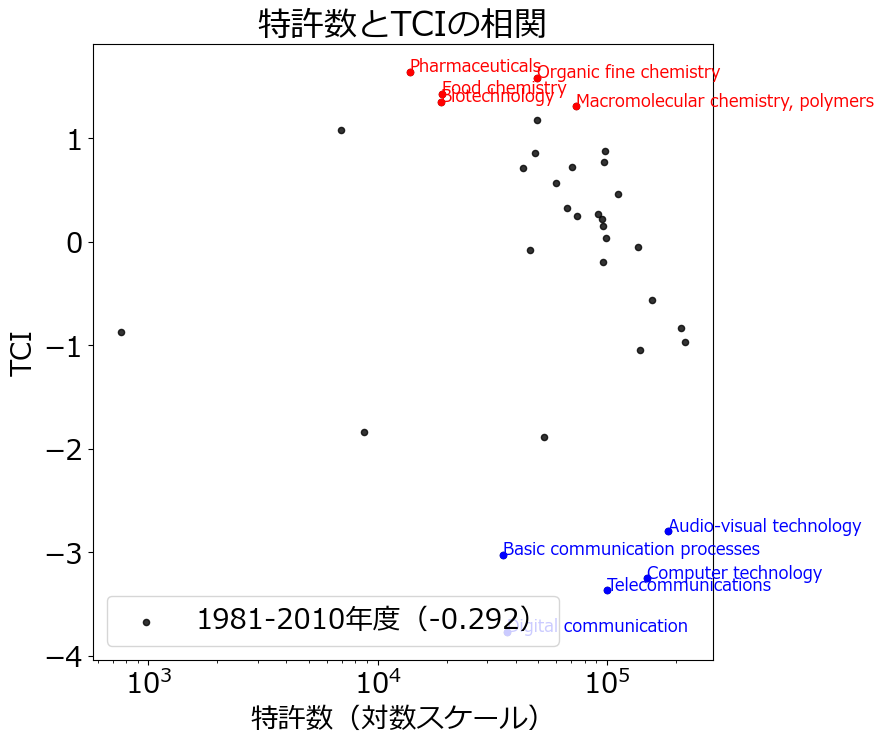

1981-2010 0.594


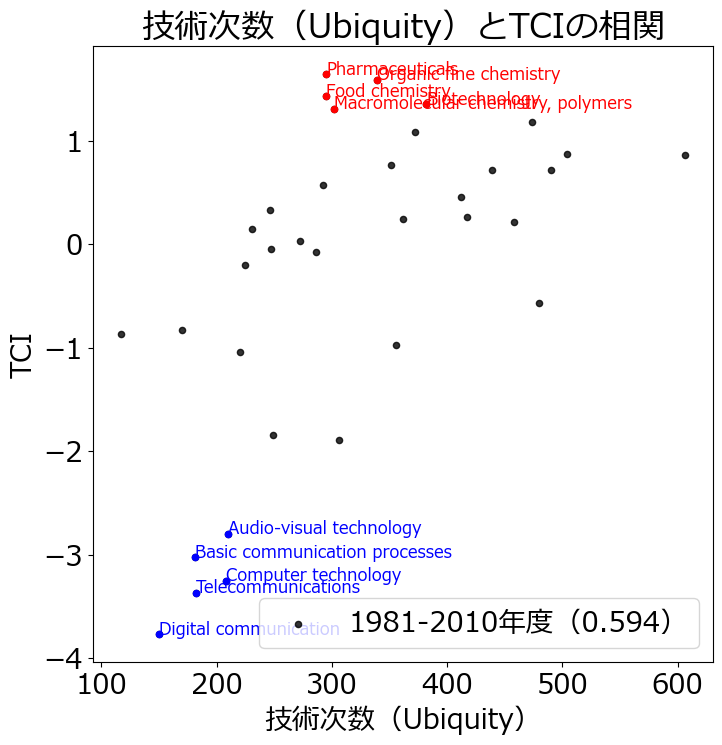

1981-2010 0.065


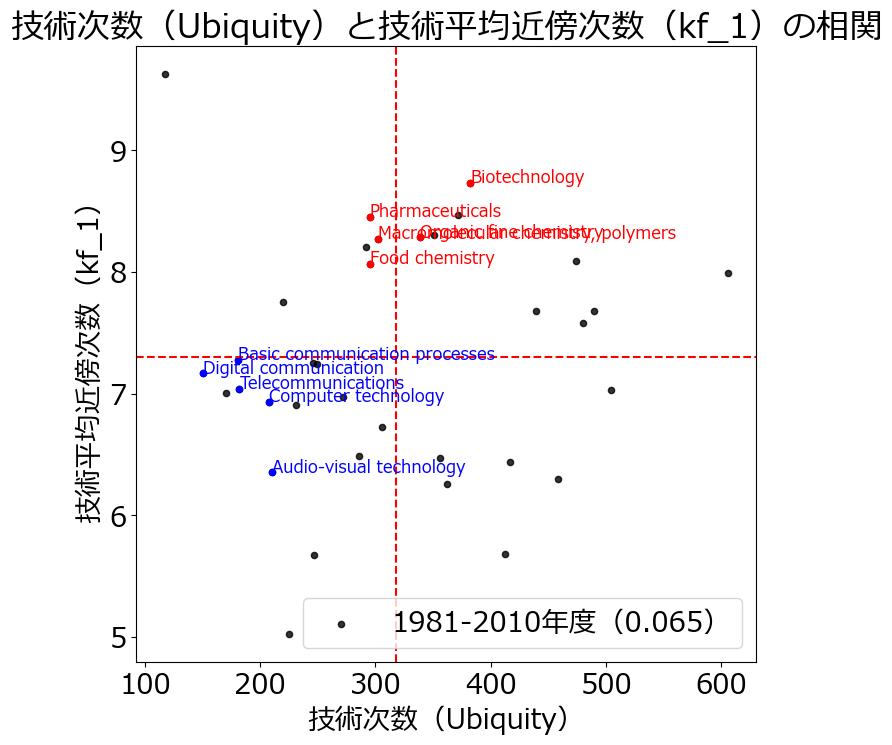

1981-2010 0.151


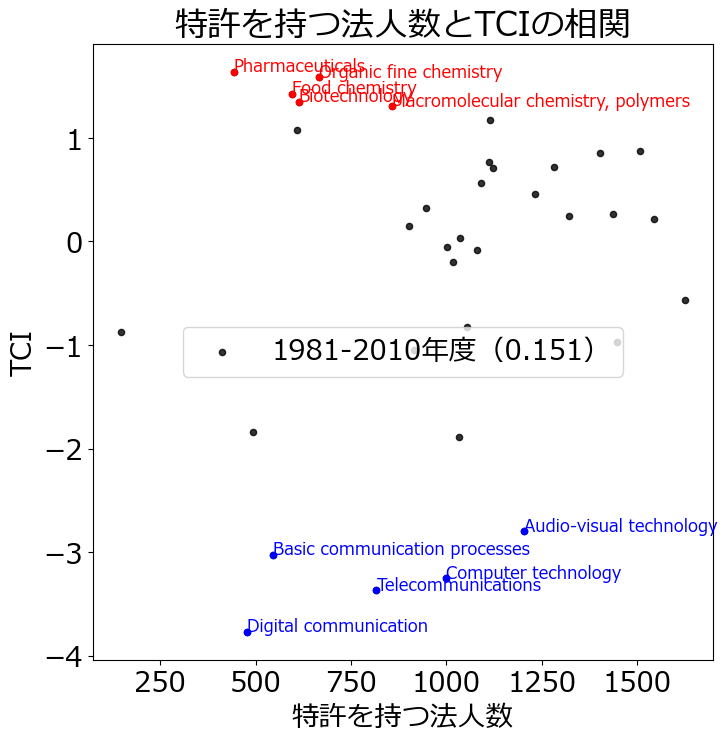

In [8]:
df_dict = {}
combi_dict = {  # ind: [x, y, title, xlabel, ylabel, legend_loc]
    1: ["reg_num", "ubiquity", "特許数と技術次数（Ubiquity）の相関", "特許数（対数スケール）", "技術次数（Ubiquity）", "lower right", ],
    2: ["reg_num", "tci", "特許数とTCIの相関", "特許数（対数スケール）", "TCI", "lower left", ],
    3: ["ubiquity", "tci", "技術次数（Ubiquity）とTCIの相関", "技術次数（Ubiquity）", "TCI", "lower right", ],
    4: ["ubiquity", "ki_1", "技術次数（Ubiquity）と技術平均近傍次数（kf_1）の相関", "技術次数（Ubiquity）", "技術平均近傍次数（kf_1）", "lower right", ],
    5: ["right_person_name", "tci", "特許を持つ法人数とTCIの相関", "特許を持つ法人数", "TCI", "center",  ],
}

for i, combi in combi_dict.items():
    fig, ax = plt.subplots(figsize=(8, 8))
    period = f"{year_start}-{year_end}"
    corr_num = round(df[df[f"{ar}_{year_style}_period"] == period][combi[0]].corr(df[df[f"{ar}_{year_style}_period"] == period][combi[1]]), 3)
    print(period, corr_num)
    ax.scatter(df[df[f"{ar}_{year_style}_period"] == period][combi[0]], df[df[f"{ar}_{year_style}_period"] == period][combi[1]],
               s=20, alpha=0.8, label=f"{period}年度（{corr_num}）", color="black", )
    if i == 4:
        ax.axvline(x=df[df[f"{ar}_{year_style}_period"] == period][combi[0]].mean(), color="red", linestyle="--", )
        ax.axhline(y=df[df[f"{ar}_{year_style}_period"] == period][combi[1]].mean(), color="red", linestyle="--", )
    ax.set_title(combi[2])
    if combi[0] in ["reg_num"]: ax.set_xscale("log")
    if combi[1] in ["reg_num"]: ax.set_yscale("log")
    x_min = df[(df[f"{ar}_{year_style}_period"] == period)][combi[0]].min()
    x_2smallest = (df[(df[f"{ar}_{year_style}_period"] == period)][combi[0]].nsmallest(2).iloc[1])
    y_2smallest = (df[(df[f"{ar}_{year_style}_period"] == period)][combi[1]].nsmallest(2).iloc[1])
    if i in [2, 3, 4, 5]:
        head_df = (df[(df[f"{ar}_{year_style}_period"] == period)].sort_values("tci", ascending=False).reset_index(drop=True).head(5))
        tail_df = (df[(df[f"{ar}_{year_style}_period"] == period)].sort_values("tci", ascending=False).reset_index(drop=True).tail(5))
        for i, row in head_df.iterrows():
            ax.text(row[combi[0]], row[combi[1]], row["schmoch35"], fontsize=12, color="red")
            ax.scatter(row[combi[0]], row[combi[1]], s=20, color="red")
            
        for i, row in tail_df.iterrows():
            ax.text(row[combi[0]], row[combi[1]], row["schmoch35"], fontsize=12, color="blue", )
            ax.scatter(row[combi[0]], row[combi[1]], s=20, color="blue")
    ax.set_ylabel(combi[4])
    ax.set_xlabel(combi[3])
    ax.legend(loc=combi[5], fontsize=20)
    plt.show()


In [24]:
# fig, ax = plt.subplots(figsize=(20, 40), squeeze=False, sharey=False)
def plot_to_image(f):
    buf = io.BytesIO()
    f.savefig(buf, format="png", bbox_inches="tight")
    plt.close()
    buf.seek(0)
    img = Image.open(buf)
    return img


color_count = 0
img_list = []
for period in range(year_start, year_end + 1, year_range):

    fig, ax = plt.subplots(figsize=(3, 30))
    period = f"{period}-{period+year_range-1}"
    plot_df = (
        df[df[f"{ar}_{year_style}_period"] == period]
        .groupby([classification])[["reg_num"]]
        .sum()
        .sort_values("reg_num", ascending=True)
    )
    ax.barh(
        list(plot_df.index),
        list(plot_df["reg_num"].values),
        color=color_list[color_count],
        label=period,
    )
    ax.set_yticklabels(plot_df.index, fontsize=15)
    ax.set_xticklabels(
        [x for x in range(0, 80000 + 1, 20000)], fontsize=20, rotation=90
    )
    ax.set_xlim(0, 90000)
    # ax.set_xticklabels(fontsize=15, rotation=90)
    xax2 = ax.secondary_xaxis("top")
    # xax2.xaxis.set_major_formatter(ptick.FuncFormatter(lambda x, _: f'{int(x):,}'))
    xax2.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=20, rotation=90)
    xax2.set_xlim(ax.get_xlim())
    ax.legend(fontsize=20, loc="upper center")
    ax.set_axisbelow(True)
    ax.grid(which="major", axis="x", linestyle="--")
    c_i = 0
    for c in plot_df.index:
        reg_num = plot_df[plot_df.index == c]["reg_num"].values[0]
        ax.text(x=40000, y=c_i, s=round(reg_num, 1), fontsize=20, color="black")
        #     ax.set_xticklabels(df[df[f'{ar}_{year_style}_period'] == period].groupby([classification])['reg_num'].sum().index, rotation=90, fontsize=15)
        c_i += 1
    color_count += 1
    img_list.append(plot_to_image(fig))

    # fig.savefig(f'{output_dir}{ar}_{year_style}_{classification}_{period}.png', bbox_inches='tight')
combined_img = Image.new(
    "RGB", (sum([img.width for img in img_list]), img_list[0].height)
)
w, h = 0, 0
for img_i, img in enumerate(img_list):
    combined_img.paste(img, (w, h))
    w += img.width
combined_img.save(f"{output_dir}tech_reg_num/{fig_name_base}", "PNG")
# combined_img.show()
plt.show()

C:\Users\rin\AppData\Local\Temp\ipykernel_18764\421203287.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(plot_df.index, fontsize=15)
C:\Users\rin\AppData\Local\Temp\ipykernel_18764\421203287.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([x for x in range(0, 80000+1, 20000)], fontsize=20, rotation=90)
C:\Users\rin\AppData\Local\Temp\ipykernel_18764\421203287.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  xax2.set_xticklabels([int(i) for i in ax.get_xticks()], fontsize=20, rotation=90)
C:\Users\rin\AppData\Local\Temp\ipykernel_18764\421203287.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(plot_df.index, fontsize=15)
C:\Users\rin\AppData\Local\Temp\ipykernel_18764\421203287.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([x for x in

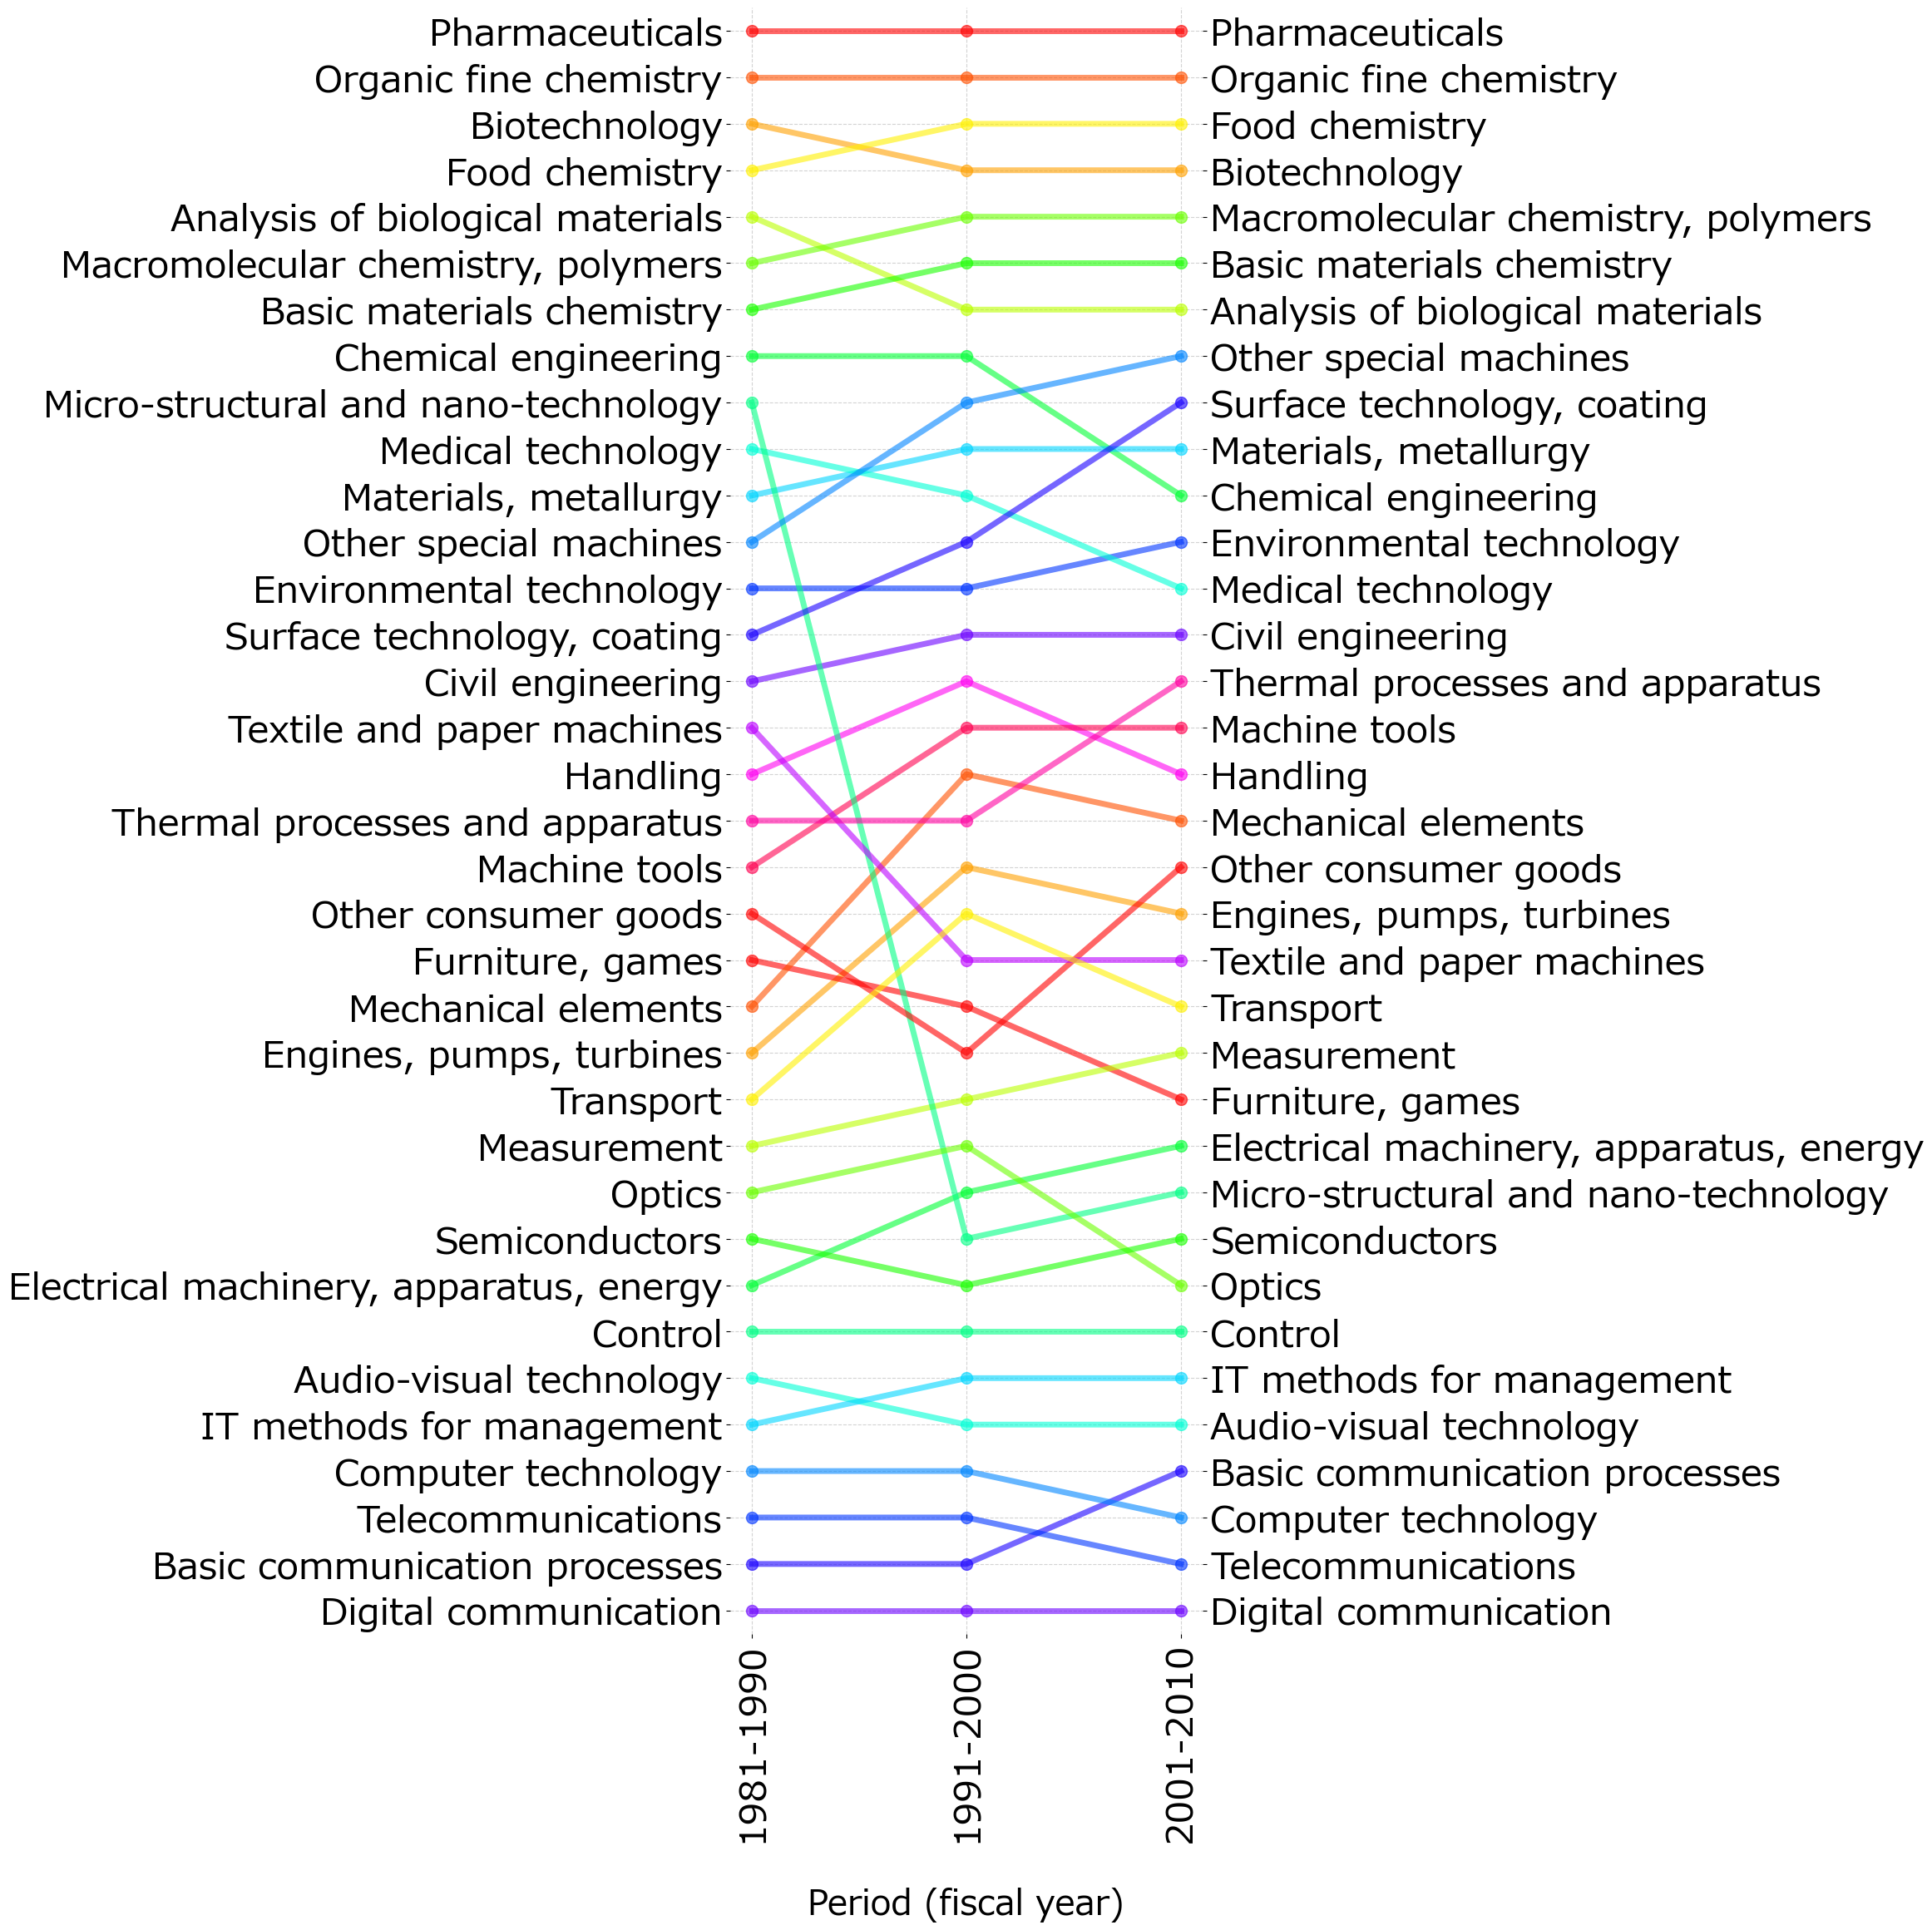

In [17]:
df_dict = {}
combi_dict = {
    #   5: [classification, 'ubiquity', f'IPC次数(=ubiquity, k_i0)ランキング 低次数Top15の推移（出願期間：{year_start}-{year_end}年度）', True],
    #   5: [classification, 'ubiquity', f'', True],
    #   6: ['ipc_class', 'ubiquity', f'IPC次数(=ubiquity, k_i0)ランキング 高次数Top15の推移（出願期間：{year_start}-{year_end}年度）', False],
    #   7: ['ipc_class', 'pci', f'TCI(Technological Compexity Index)ランキング 値が低いものTop15の推移（出願期間：{year_start}-{year_end}年度）', True],
    #   8: [classification, 'tci', f'TCI(Technological Compexity Index)ランキング 値が高いものTop15の推移（出願期間：{year_start}-{year_end}年度）', False]
    8: [classification, "tci", "", False]
}


for i, combi in combi_dict.items():
    div_df = (
        df[[f"{ar}_{year_style}_period"] + combi[: 1 + 1]]
        .sort_values(
            by=[f"{ar}_{year_style}_period", combi[1]], ascending=[True, False]
        )
        .copy()
    )
    div_df = div_df.drop_duplicates(keep="first")
    div_df_dict = {}
    for year in range(year_start, year_end + 1, year_range):
        period = f"{year}-{year+year_range-1}"
        div_df_dict[period] = div_df[
            div_df[f"{ar}_{year_style}_period"] == period
        ].copy()
        # display(div_df_dict[f'{year}-{year+year_range-1}'].head(15))
    if i == 4:
        df["kci_rank"] = (
            df.groupby(f"{ar}_{year_style}_period")[["kci"]]
            .rank(ascending=False, method="first")
            .reset_index(drop=False)["kci"]
        )
        # display(c_df[c_df['right_person_name'].str.contains('三菱重工業')])
    if i > 4:
        fs = (24, 24)
    else:
        fs = (10, 12)
    # display(div_df)
    sample = vr.rank_doubleaxis(
        div_df_dict,
        version="kci",
        rank_num=35,
        member_col=combi[0],
        num_col=combi[1],
        prop_dict={
            "figsize": fs,
            "xlabel": "期間",
            "ylabel": "",
            "title": combi[2],
            "fontsize": 32,
            "year_range": year_range,
            "ascending": combi[3],
            # 'color': color_dict
            "color": "default",
        },
    )
    # plt.tight_layout()
    plt.xlabel("\nPeriod (fiscal year)", fontsize=30)
    plt.savefig(
        f"{output_dir}/figures/{combi[1]}_{ar}_{year_style}_{top_p_or_num[0]}_{top_p_or_num[1]}.png",
        bbox_inches="tight",
    )
    plt.show()

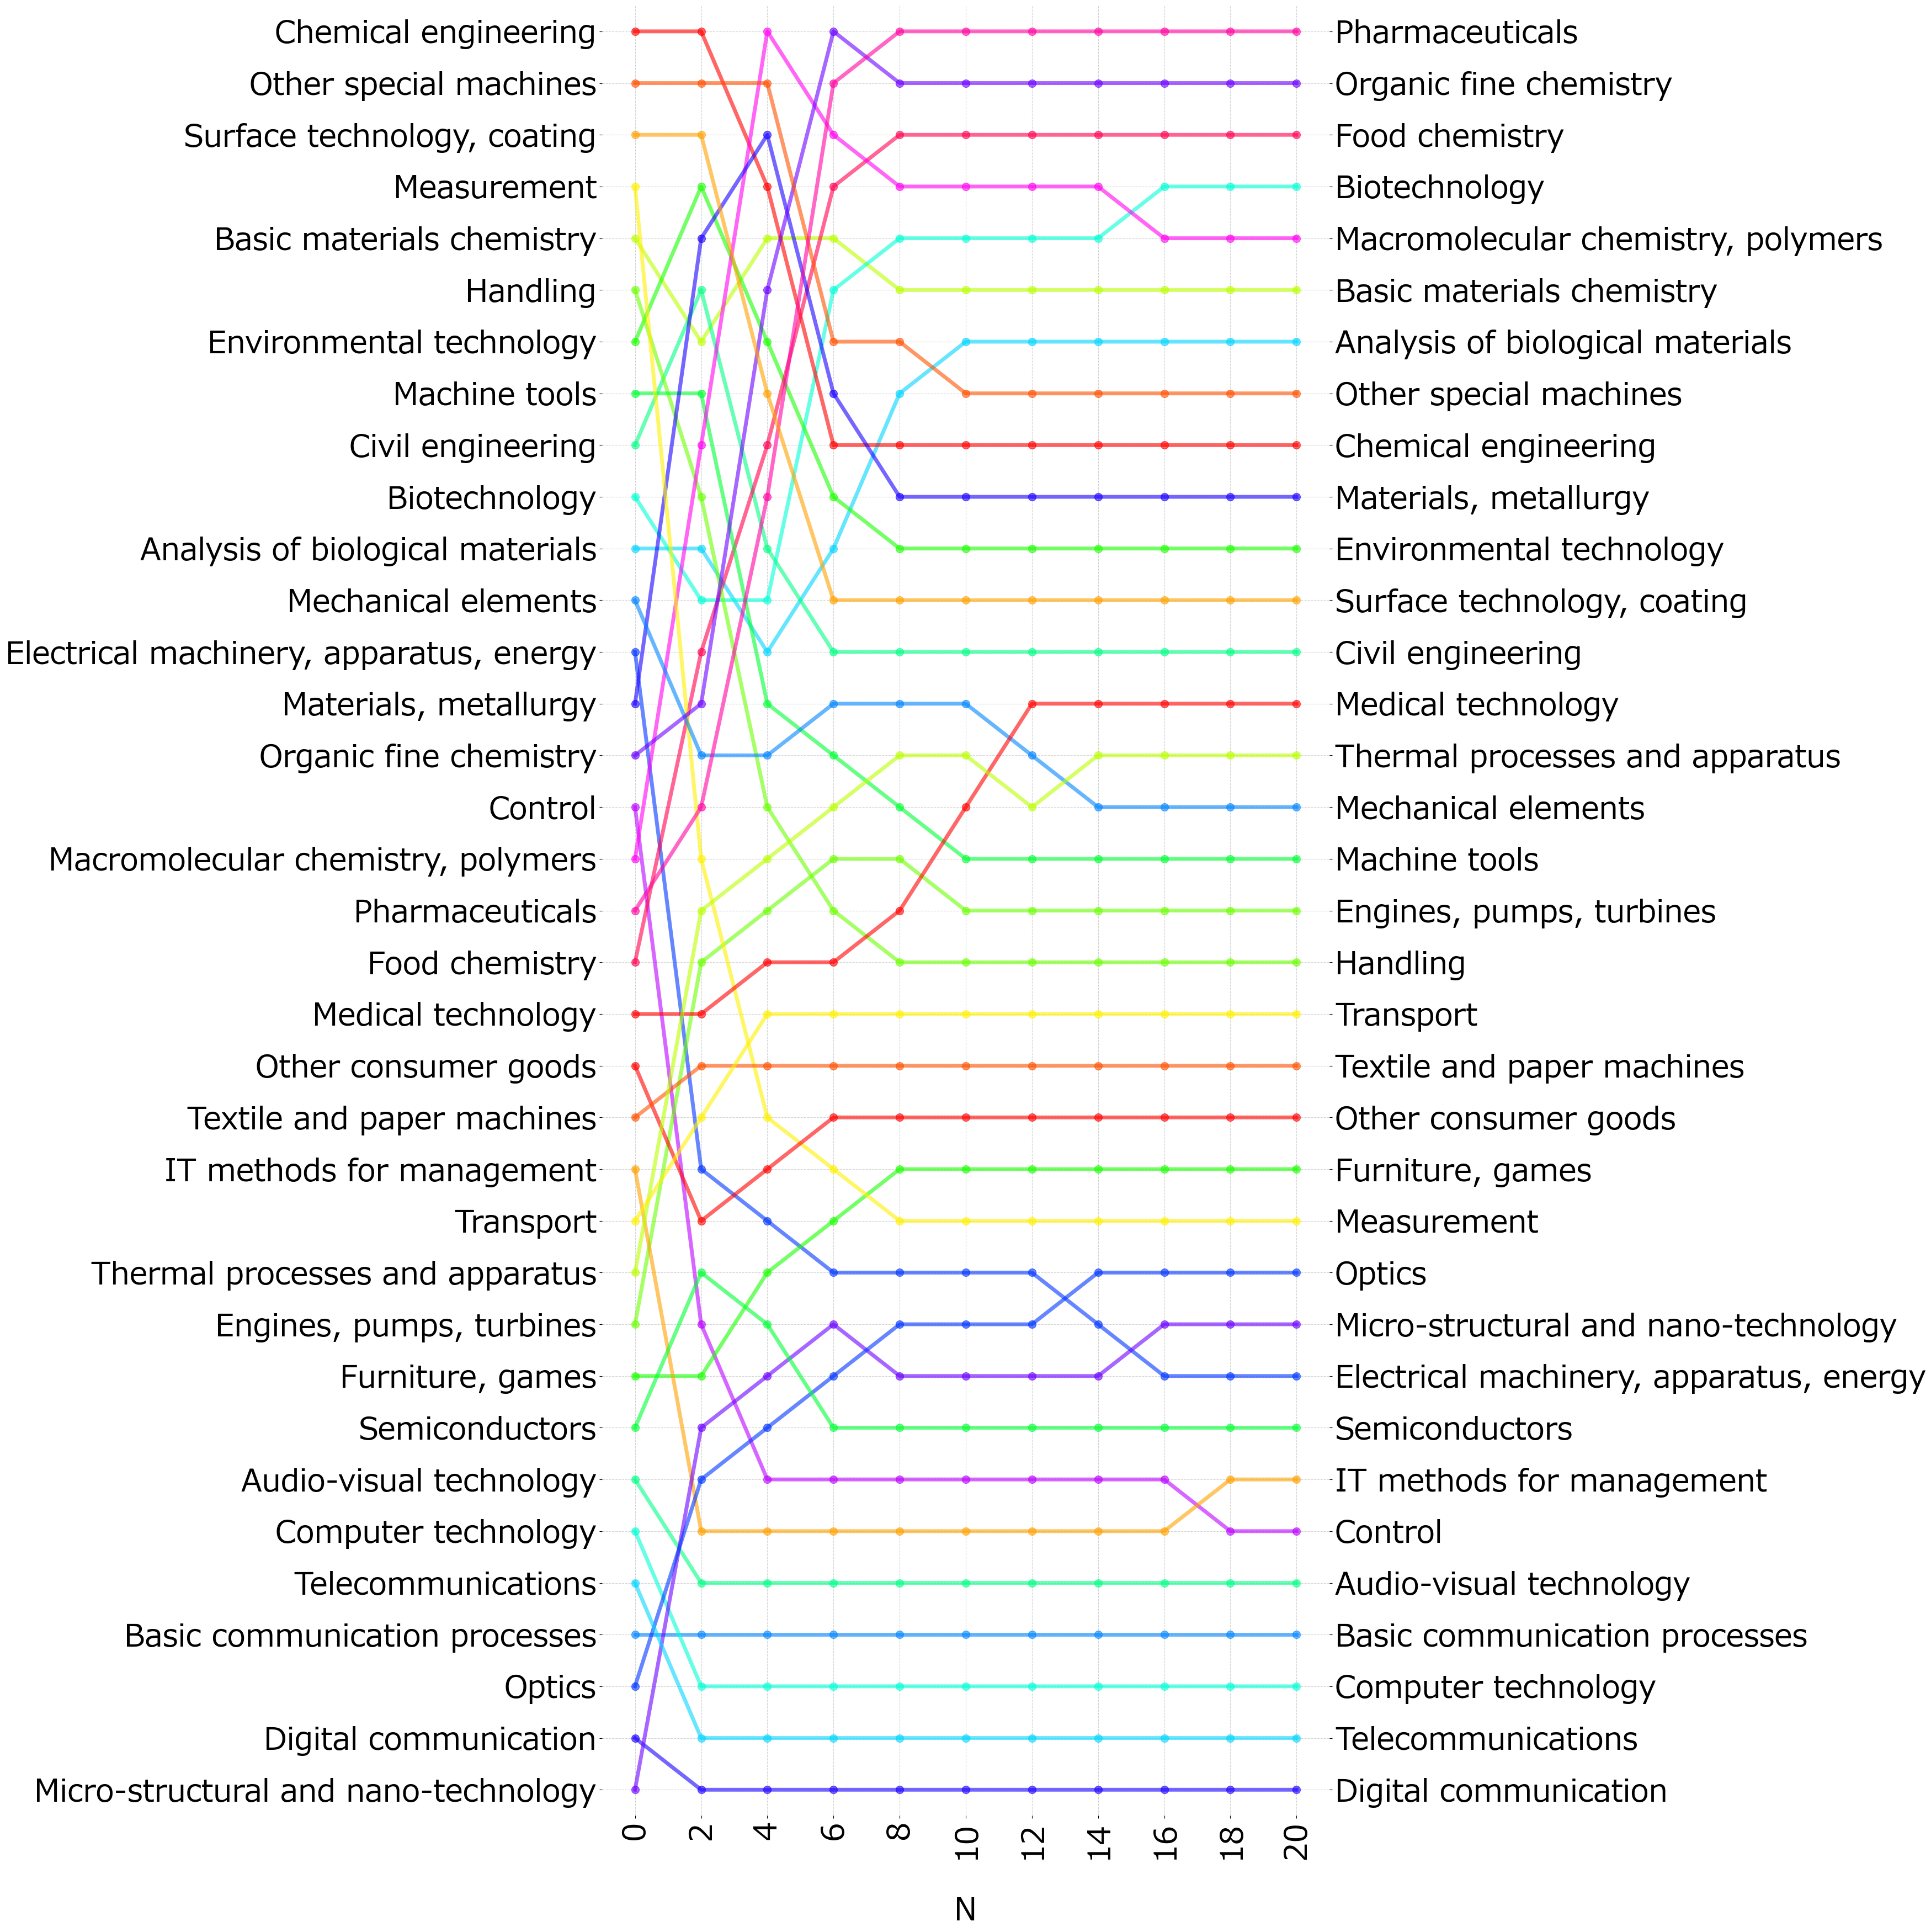

In [18]:
sample_df = (
    df[(df[f"{ar}_{year_style}_period"] == f"{year_start}-{year_end}")]
    .sort_values("tci", ascending=False)
    .copy()

)
sample_df_dict = {
    "0": sample_df.melt(id_vars=[classification], value_vars=["ubiquity"]).sort_values(
        "value", ascending=False
    )
}

fs = (36, 36)

for i in range(2, 20 + 1, 2):

    sample_df_dict[f"{i}"] = sample_df.melt(
        id_vars=[classification], value_vars=[f"ki_{i}"]
    ).sort_values("value", ascending=False)

    # if i >= 12: display(sample_df_dict[f'{i}'].head(10))

sample = vr.rank_doubleaxis(
    sample_df_dict,

    version="kci",

    rank_num=35,

    member_col=classification,
    num_col="value",

    prop_dict={

        "figsize": fs,

        "xlabel": "N",

        "ylabel": "",
        "title": "",

        "fontsize": 40,

        "year_range": 2,
        "ascending": False,
        # 'color': color_dict
        "color": "default",

    },
)